In [1]:
import polaris as po
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
import numpy as np
from stepmix.stepmix import StepMix
import re


/Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# ADMET


## Summary of missingness

Let's first look at the state of the training data and see how many missing there are for each target. 

In [24]:
challenge = "antiviral-admet-2025"

competition = po.load_competition(f"asap-discovery/antiviral-admet-2025")
competition.cache()
train, test = competition.get_train_test_split()


[2025-02-22 18:17:44] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=969057;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=671482;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.8).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=579036;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=928242;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

/Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[18:17:45] Copying to destination                                                                      ]8;id=902186;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=188698;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#380\380]8;;\
           /Users/robertarbon/Library/Caches/polaris/datasets/0e9f9d49-cb35-46ed-a664-583ba91ae450/dat             
           a.zarr                                                                                                  

           For large Zarr archives, this may take a while.                                             ]8;id=8931;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=752921;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#381\381]8;;\

            Success: Copying Zarr keys                                                                ]8;id=919556;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=961355;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=541099;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=917819;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

In [25]:
train_df = train.as_dataframe()
train_df.isna().sum(axis=0)

CXSMILES         0
HLM            133
MDR1-MDCKII      9
MLM            131
KSOL            69
LogD            82
dtype: int64

The missing values represent either assays that haven't been run (true missing) or are above or below the assay detection limits (censored). 
With the correct model (e.g., ordinal regression) censored data can be utilised.  So I'm gonna get the censored values back in.  Unfortunately we can't use the SMILES strings because they aren't unique, as there are unknown stereochemistries: 

In [26]:
print(f"num obs: {train_df.shape[0]}, num unique smiles: {len(set(train_df['CXSMILES']))}")

vals, idx, counts = np.unique(train_df['CXSMILES'].values, return_counts=True, return_index=True)
print(f"num mols with 2 enantiomers: {vals[counts==2].shape[0]}")

num obs: 434, num unique smiles: 404
num mols with 2 enantiomers: 30


These are labelled with the 'OR' stereochemistry in CXSMILES: 

In [27]:
vals[counts==2][:2]

array(['CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N=C1)N2)C1=CC=C2OCCOC2=C1 |o1:4|',
       'CC(C)(C)[C@H](NC1=NC=NC2=C1C=C(C1=CN(CC(N)=O)N=C1)N2)C1=CC=C2OCCOC2=N1 |o1:4|'],
      dtype=object)

So we will need to use the molecule name. while we're here, we'll do the potentency as well  

## Add in censored values

In [6]:
def get_all_data(ds) -> pd.DataFrame: 
    columns = ds.columns    
    n_rows = ds.n_rows

    data = {k: [ds.get_data(i, k) for i in range(n_rows)] for k in columns}
    df = pd.DataFrame(data) 
    return df

In [28]:
all_df = get_all_data(train.dataset) # This is all data including the test set. 
df = all_df.loc[competition.split[0], : ]
test_df = all_df.loc[competition.split[1]['test'], :]


In [29]:
test_df.head()

,CXSMILES,HLM,KSOL,LogD,MDR1-MDCKII,MLM,Molecule Name
434,CC(C)[C@H]1C2=C(CCN1C(=O)CC1=CN=CC3=CC=CC=C13)...,NaN,NaN,NaN,NaN,NaN,ASAP-0031558
435,CC(C)C1(C)CCN(C(=O)CC2=CN=CC3=CC=CC=C23)CC1,NaN,NaN,NaN,NaN,NaN,ASAP-0031372
436,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC2=C(C=CS2)C12CCC2,NaN,NaN,NaN,NaN,NaN,ASAP-0031411
437,CC1(CC(F)(F)F)CCN(C(=O)CC2=CN=CC3=CC=CC=C23)CC1,NaN,NaN,NaN,NaN,NaN,ASAP-0031442
438,CCC1=CC=C([C@H]2C[C@H](C)CCN2C(=O)CC2=CN=CC3=C...,NaN,NaN,NaN,NaN,NaN,ASAP-0031187


We don't need to do anything more with the test data so just save it (with the molecule name)

In [30]:
test_df.loc[:, ['Molecule Name', 'CXSMILES']].to_csv('data/test_admet_all.csv', index=False)

In [31]:
df['n_missing'] = df.isna().sum(axis=1)
df.loc[df.n_missing < 5, :].shape

(434, 8)

Now we can fetch all the censored values from the raw data

In [32]:
target_to_raw = {'MLM': 
                    {'measurement_col': 'in-vitro_MLM_bienta: CLint (Num) (uL/min/mg)', 
                     'mod_col': 'in-vitro_MLM_bienta: CLint (Mod)', 
                     'train_name': 'MLM'},
                  'HLM':
                     {'measurement_col': 'in-vitro_HLM_bienta: CLint (Num) (uL/min/mg)', 
                      'mod_col': 'in-vitro_HLM_bienta: CLint (Mod)', 
                      'train_name': 'HLM'}, 
                  'KSOL':
                     {'measurement_col': 'in-vitro_KSOL-PBS_bienta: mean_solubility (Num) (uM)', 
                     'mod_col': 'in-vitro_KSOL-PBS_bienta: mean_solubility (Mod)', 
                     'train_name': 'KSOL'},   
                  'LogD':
                     {'measurement_col': 'in-vitro_LogD_bienta: LogD (Num)', 
                     'mod_col': 'in-vitro_LogD_bienta: LogD (Mod)', 
                     'train_name': 'LogD'}, 
                  'MDR1-MDCK2':
                     {'measurement_col': 'in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Num) (10^-6 cm/s)', 
                     'mod_col': 'in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Mod)', 
                     'train_name': 'MDR1-MDCKII'},   
                 }




In [33]:

old_n_missing = df.loc[:, list(train.target_cols)].isna().sum(axis=1)

dupes_to_check = {}

for target in target_to_raw.keys():

    raw = pd.read_csv(f'raw_data_package/admet/ADMET_{target}_CONFIDENTIAL.csv')

    to_merge = raw.loc[:, ['Molecule Name', target_to_raw[target]['measurement_col'],target_to_raw[target]['mod_col'], 'CXSMILES (CDD Compatible)']]


    not_eqs_symbs = to_merge[target_to_raw[target]['mod_col']].unique()
    not_eqs_symbs = [x for x in not_eqs_symbs if x !='=']

    to_merge = to_merge.loc[to_merge[target_to_raw[target]['mod_col']].isin(not_eqs_symbs), :]

    duplicates = to_merge.duplicated(keep=False)

    to_merge = to_merge.drop_duplicates()

    dupes_to_check[target] = duplicates

    # Check whether 'censored' value really is out of the range of the other values
    min_cval, max_cval = to_merge[target_to_raw[target]['measurement_col']].min(), to_merge[target_to_raw[target]['measurement_col']].max()
    min_val, max_val = df[target_to_raw[target]['train_name']].min(), df[target_to_raw[target]['train_name']].max()

    if (min_val < min_cval) or (max_val > max_cval): 
        print(f"WARNING: {target}: {min_val}<{min_cval}, {max_val}>{max_cval}..")
    
    clip_vals = to_merge.groupby(target_to_raw[target]['mod_col'])[target_to_raw[target]['measurement_col']].unique()
    print(f'{target} clipping values: \n{clip_vals}\n')


    # Check merging process
    old_n = df.shape[0]

    tmp = df.merge(right=to_merge, on='Molecule Name', how='left')
    new_n = tmp.shape[0]
    ix = tmp['CXSMILES (CDD Compatible)'].isna()
    tmp.loc[ix, 'CXSMILES (CDD Compatible)'] = tmp.loc[ix, 'CXSMILES']

    smiles_matching = np.all(tmp['CXSMILES (CDD Compatible)'].values == tmp['CXSMILES'].values)

    if (old_n == new_n) and smiles_matching: 
        df = tmp
        target_na = df[target_to_raw[target]['train_name']].isna()
        
        # update missing values
        df.loc[target_na, target_to_raw[target]['train_name']] = df.loc[target_na, target_to_raw[target]['measurement_col']].values
        del df['CXSMILES (CDD Compatible)']

    else: 
        print('ERROR', old_n, new_n, smiles_matching, target)
        print(target,' not added to dataset')
        pass 



new_n_missing =  df.loc[:, list(train.target_cols)].isna().sum(axis=1)
print(f'Replaced {old_n_missing.sum() - new_n_missing.sum()}, only {new_n_missing.sum()} or {new_n_missing.sum()/(5*new_n_missing.shape[0]):4.2%} missing')
df.shape


MLM clipping values: 
in-vitro_MLM_bienta: CLint (Mod)
<    [10.0]
Name: in-vitro_MLM_bienta: CLint (Num) (uL/min/mg), dtype: object

HLM clipping values: 
in-vitro_HLM_bienta: CLint (Mod)
<    [10.0]
Name: in-vitro_HLM_bienta: CLint (Num) (uL/min/mg), dtype: object

KSOL clipping values: 
in-vitro_KSOL-PBS_bienta: mean_solubility (Mod)
>=    [400.0]
≤       [2.0]
≥     [400.0]
Name: in-vitro_KSOL-PBS_bienta: mean_solubility (Num) (uM), dtype: object

LogD clipping values: 
in-vitro_LogD_bienta: LogD (Mod)
≤        [-1.0]
≥    [4.5, 1.9]
Name: in-vitro_LogD_bienta: LogD (Num), dtype: object

MDR1-MDCK2 clipping values: 
Series([], Name: in-vitro_MDR1-MDCKII-Papp_bienta: mean_Papp_A_to_B (Num) (10^-6 cm/s), dtype: float64)

Replaced 168, only 256 or 11.80% missing


(434, 18)

The >=1.9 in the LogD measurements occurs only once.  I'm going to leave that in there - I don't think it will make much of a difference.  

There are '=' values that are lower than the lower bound for MLM and HLM. I will clip these manually because according to the experimenters they think these are wrong anyway. 

In [34]:
df.loc[:, "MLM"] = df['MLM'].clip(lower=10)
df.loc[:, 'HLM'] = df['HLM'].clip(lower=10)

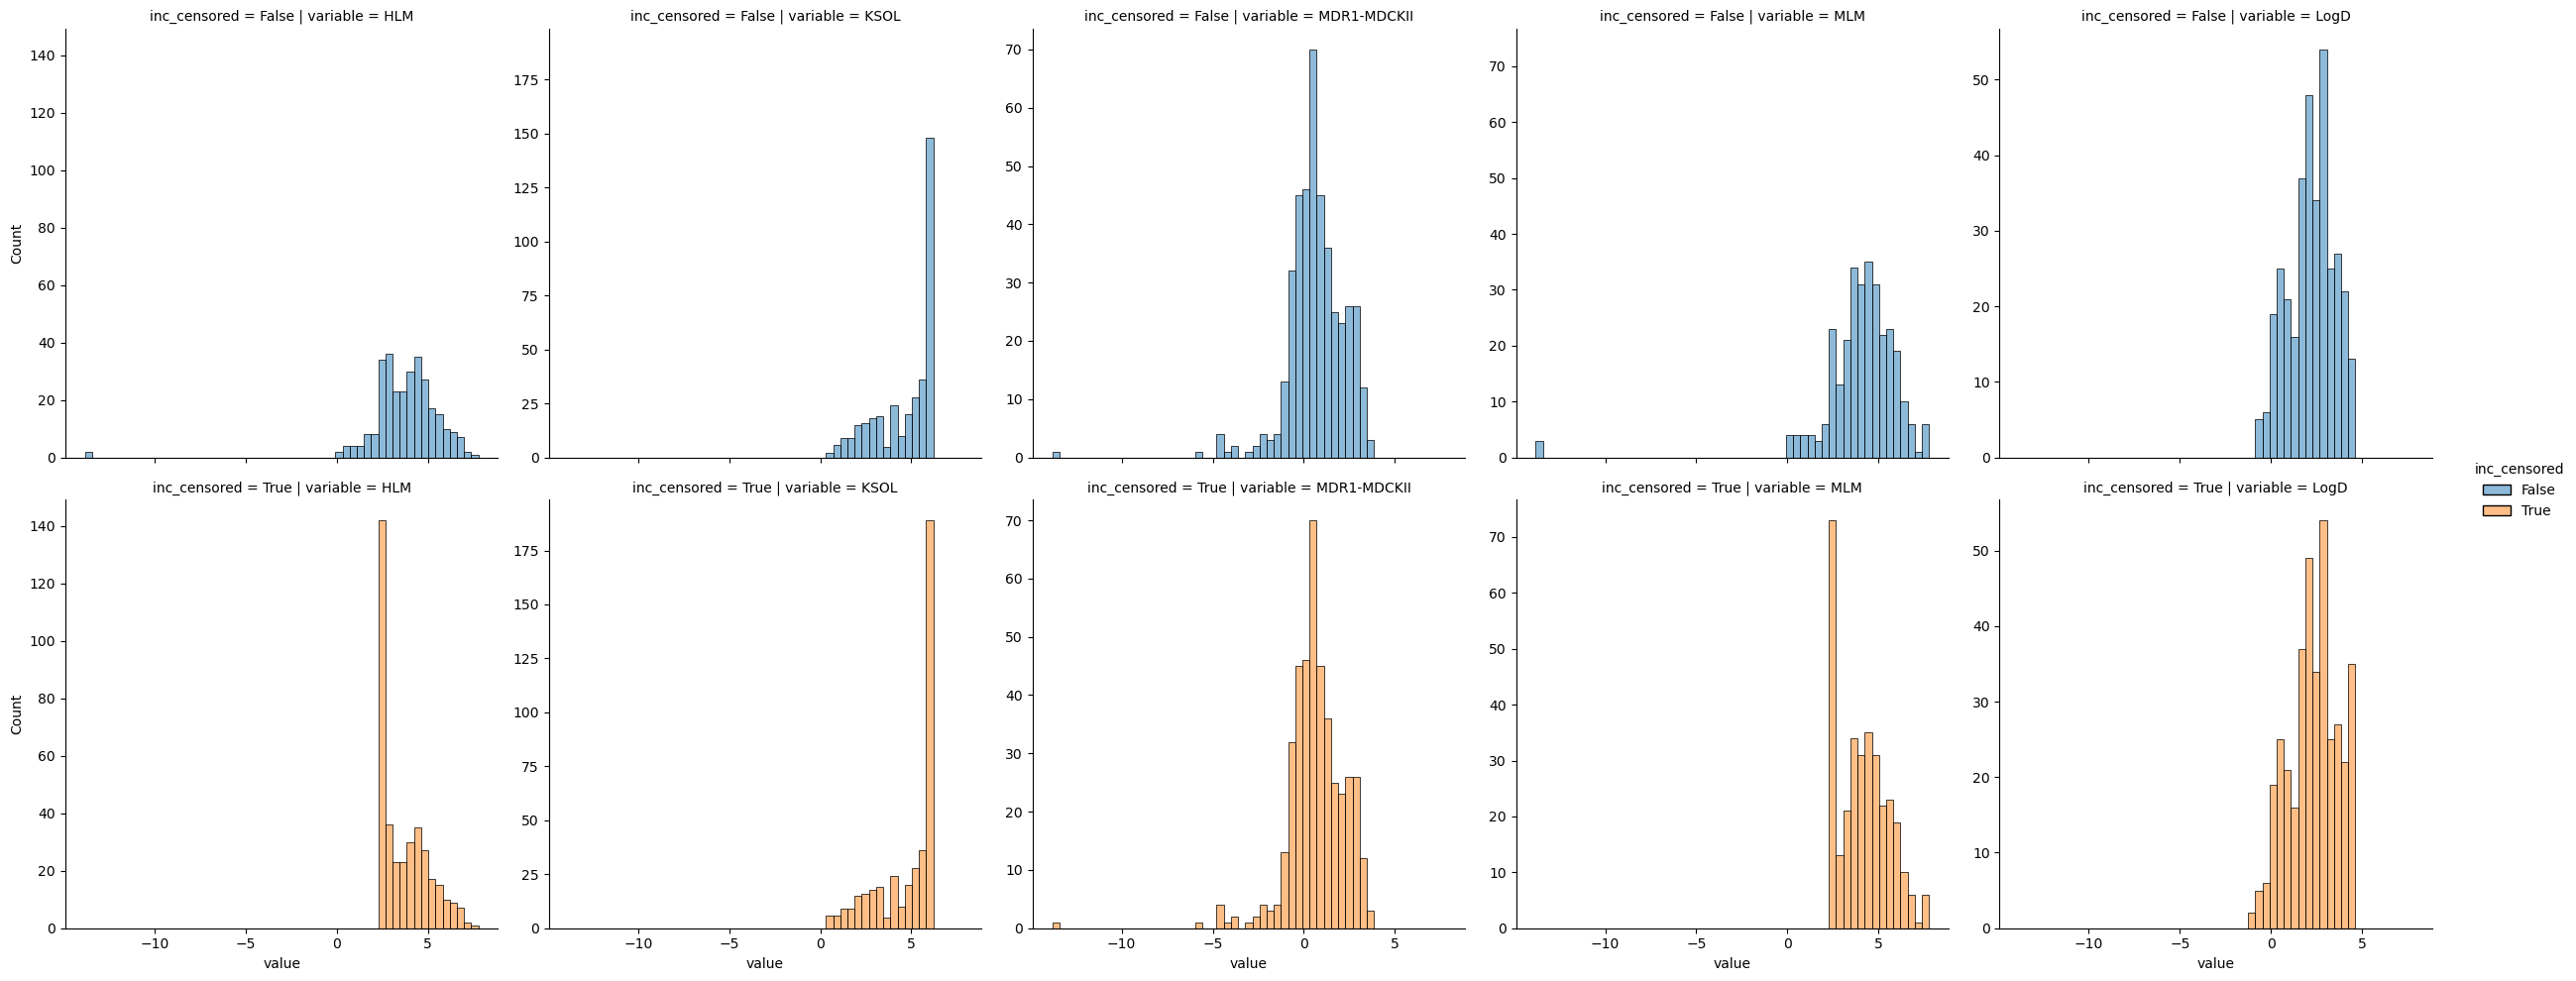

In [37]:
to_plot = df.loc[:, ['HLM', 'KSOL', 'MDR1-MDCKII', 'MLM', 'LogD']]
to_plot['inc_censored'] = True
tmp = train_df.copy(deep=True)

tmp['inc_censored'] = False

to_plot = pd.concat([tmp.loc[:,['HLM', 'KSOL', 'MDR1-MDCKII', 'MLM', 'LogD', 'inc_censored'] ], to_plot], axis=0)


to_plot.loc[:, ['HLM', 'KSOL', 'MDR1-MDCKII', 'MLM']] = np.log(to_plot.loc[:, ['HLM', 'KSOL', 'MDR1-MDCKII', 'MLM']] + 1e-6)


sns.displot(data=to_plot.melt(id_vars='inc_censored'), x='value', col='variable', hue='inc_censored',  row='inc_censored', facet_kws=dict(sharex='col', sharey='col'))

In [38]:
df.to_csv('data/train_admet_all.csv', index=False)

# Potency

In [40]:
competition = po.load_competition(f"asap-discovery/antiviral-potency-2025")
competition.cache()
train, test = competition.get_train_test_split()

[2025-02-22 18:20:55] INFO     The version of Polaris that was used to create the artifact (0.11.0) ]8;id=988597;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=697488;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/_artifact.py#92\92]8;;\
                               is different from the currently installed version of Polaris                        
                               (0.11.8).                                                                           

                      WARNING  You're loading data from a remote location. If the dataset is small     ]8;id=786379;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=42362;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#181\181]8;;\
                               enough, consider caching the dataset first using                                    
                               CompetitionSpecification.cache() for more performant data access.                   

/Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

[18:20:55] Copying to destination                                                                      ]8;id=924219;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=264228;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#380\380]8;;\
           /Users/robertarbon/Library/Caches/polaris/datasets/ac1779b4-4d41-4267-892f-ae4995409bcf/dat             
           a.zarr                                                                                                  

           For large Zarr archives, this may take a while.                                             ]8;id=216408;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py\_base.py]8;;\:]8;id=124704;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/dataset/_base.py#381\381]8;;\

[18:20:56]  Success: Copying Zarr keys                                                                ]8;id=185582;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=126900;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

            Success: Copying Zarr archive                                                             ]8;id=675634;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=215736;file:///Users/robertarbon/mamba/envs/polaris/lib/python3.12/site-packages/polaris/utils/context.py#53\53]8;;\

In [41]:
train_df = train.as_dataframe()
train_df.isna().sum(axis=0)

CXSMILES                     0
pIC50 (MERS-CoV Mpro)      130
pIC50 (SARS-CoV-2 Mpro)    189
dtype: int64

Get the data with the molecule name. 

In [42]:
all_df = get_all_data(train.dataset) # This is all data including the test set. 
df = all_df.loc[competition.split[0], : ]
test_df = all_df.loc[competition.split[1]['test'], :]

Save the test set - don't need it any more. 

In [44]:
test_df.to_csv('data/test_potency_all.csv', index=False)

We need to check whether any of the values have been censored - we first need to match up the reported values with the column in the raw data (its not totally obvious)

In [50]:
df.sort_values(by=['Molecule Name']).head()

,CXSMILES,Molecule Name,pIC50 (MERS-CoV Mpro),pIC50 (SARS-CoV-2 Mpro)
0,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,ASAP-0000141,4.19,NaN
1,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000142,4.92,5.29
2,CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...,ASAP-0000143,4.73,NaN
3,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000144,4.90,6.11
4,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,ASAP-0000145,4.81,5.62


In [51]:
raw_mers = pd.read_csv(f'raw_data_package/potency/MERS-CoV-Mpro_potencies_CONFIDENTIAL.csv')
raw_mers.sort_values(by=['Molecule Name']).head()

,MERS-CoV-MPro_fluorescence-dose-response_weizmann: IC50 (µM),MERS-CoV-MPro_fluorescence-dose-response_weizmann: IC50 CI (Lower) (µM),MERS-CoV-MPro_fluorescence-dose-response_weizmann: IC50 CI (Upper) (µM),MERS-CoV-MPro_fluorescence-dose-response_weizmann: Curve class,MERS-CoV-MPro_fluorescence-dose-response_weizmann: Hill slope,MERS-CoV-MPro_fluorescence-dose-response_weizmann: pIC50,MERS-CoV-MPro_fluorescence-dose-response_weizmann: Minh_Protease_MERS_Mpro_pIC50 (calc) (uM),MERS-CoV-MPro_fluorescence-dose-response_weizmann: Minh_Protease_MERS_Mpro_pIC50 (calc) (uM) Standard Deviation (±),MERS-CoV-MPro_fluorescence-dose-response_weizmann: Minh_Protease_MERS_Mpro_pIC50 (calc) (uM) Count,Molecule Name,CXSMILES (CDD Compatible),Batch Created Date
944,> 9.990,NaN,NaN,NaN,NaN,< 5.0,4.19,NaN,1.0,ASAP-0000141,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,2022-08-09
943,> 99.500,NaN,NaN,NaN,NaN,< 4.0,4.19,NaN,1.0,ASAP-0000141,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,2022-08-09
942,> 9.990,NaN,NaN,NaN,NaN,< 5.0,4.92,0.842,2.0,ASAP-0000142,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,2022-08-09
941,> 99.500,NaN,NaN,NaN,NaN,< 4.0,4.92,0.842,2.0,ASAP-0000142,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,2022-08-09
940,> 9.990,NaN,NaN,NaN,NaN,< 5.0,4.73,0.655,2.0,ASAP-0000143,CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...,2022-08-09


The column used is: `MERS-CoV-MPro_fluorescence-dose-response_weizmann: Minh_Protease_MERS_Mpro_pIC50 (calc) (uM)` there is no column for the  '=' or '<', so assume it happens in the fields. 

In [55]:
raw_mers['MERS-CoV-MPro_fluorescence-dose-response_weizmann: Minh_Protease_MERS_Mpro_pIC50 (calc) (uM)'].dtype, raw_mers['MERS-CoV-MPro_fluorescence-dose-response_weizmann: pIC50'].dtype

(dtype('float64'), dtype('O'))

Double check all the molecule names in the raw data are all in the training data

In [132]:
len(set(raw_mers['Molecule Name'].values) - set(df['Molecule Name'].values)), len(set(df['Molecule Name'].values)-set(raw_mers['Molecule Name'].values))

(0, 130)

So there are 130 molecules that did have a SARS measurement but not a MERS measurement. But there are no values in the raw data that are not in the training data. 

So we can assume that there are no censored values in the raw 'MERS' data. 

In [147]:
raw_sars = pd.read_csv(f'raw_data_package/potency/SARS-CoV-2-Mpro_potencies_CONFIDENTIAL.csv') #'SARS-CoV-2-Mpro_potencies_CONFIDENTIAL'
raw_sars.sort_values(by=['Molecule Name']).head()

,SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: IC50 (µM),SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: IC50 CI (Lower) (µM),SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: IC50 CI (Upper) (µM),SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: Hill slope,SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M),Molecule Name,CXSMILES (CDD Compatible),Batch Created Date
995,> 9.990,NaN,NaN,NaN,< 5.00,ASAP-0000141,COC[C@]1(C)C(=O)N(C2=CN=CC3=CC=CC=C23)C(=O)N1C...,2022-08-09
994,5.157,4.849,5.485,1.194,5.29,ASAP-0000142,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,2022-08-09
993,> 9.990,NaN,NaN,1.463,< 5.00,ASAP-0000143,CNC(=O)CN1C[C@]2(C[C@H](C)N(C3=CN=CC=C3C3CC3)C...,2022-08-09
992,0.774,0.737,0.813,1.021,6.11,ASAP-0000144,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,2022-08-09
991,2.388,2.197,2.595,1.289,5.62,ASAP-0000145,C=C(CN1CCC2=C(C=C(Cl)C=C2)C1C(=O)NC1=CN=CC2=CC...,2022-08-09


Clearly there are censored values. Let's check what they're censoring to. 

In [148]:
measurement_col = 'SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M)'

raw_sars = raw_sars.loc[~raw_sars[measurement_col].isna(), :] # 4 of the rows contain all nans

vals, counts = np.unique(raw_sars.loc[raw_sars[measurement_col].str.contains('<|>'), measurement_col].values, return_counts=True)
pd.DataFrame({'value': vals, 'count': counts})

,value,count
0,< 4.00,246
1,< 4.49,1
2,< 5.00,9
3,< 6.40,7
4,< 6.70,8
5,> 7.30,36
6,> 7.34,2
7,> 8.00,1
8,> 8.30,1


In [149]:
(df['pIC50 (SARS-CoV-2 Mpro)']<6.7).mean(), (df['pIC50 (SARS-CoV-2 Mpro)']<5.00).mean(),  (df['pIC50 (SARS-CoV-2 Mpro)']<4.00).mean()

(0.7012609117361784, 0.3773035887487876, 0.0)

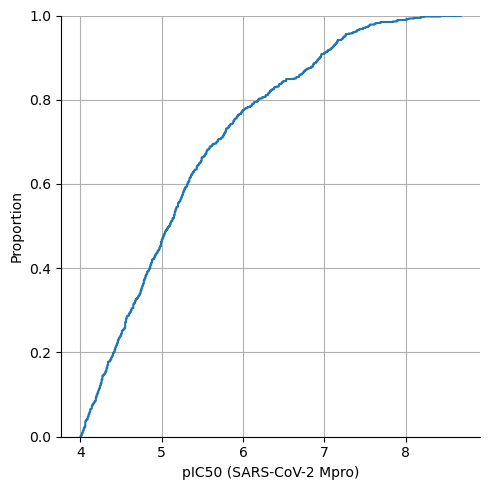

In [150]:
g = sns.displot(df['pIC50 (SARS-CoV-2 Mpro)'], kind='ecdf')
plt.gca().grid(True)

- The minimum target value of pIC50 for SARS is 7.69 so I don't think we can censore all the values above 7.3 to make one large 'very active' category. I think we can get away with censoring all those above 8.0 however. 
- 70% of the observations are below 6.7, so we can use that as the cutoff for the 'very inactive' class. We can put in the values below 4.0 back into the training data though. 

multiple values in the raw data might correspond to the same molecule however, so we need to filter out that. 

In [204]:
to_merge = raw_sars.loc[raw_sars[measurement_col].str.contains('< 4.00|> 8.'), [measurement_col, 'Molecule Name', 'CXSMILES (CDD Compatible)', 'Batch Created Date']]
dupes = to_merge.duplicated(keep=False, subset=['Molecule Name'])
to_merge.loc[dupes, :]

,SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M),Molecule Name,CXSMILES (CDD Compatible),Batch Created Date
399,< 4.00,ASAP-0011351,CC1=CC(O[C@H]2CCN(C(=O)CC3=CN=CC4=CC=CC=C34)C2...,2023-06-13
400,< 4.00,ASAP-0011351,CC1=CC(O[C@H]2CCN(C(=O)CC3=CN=CC4=CC=CC=C34)C2...,2023-06-13
403,< 4.00,ASAP-0011342,O=C(CC1=CN=CC2=CC=CC=C12)N1CC[C@H](OCC2=CC=CC=...,2023-06-13
404,< 4.00,ASAP-0011342,O=C(CC1=CN=CC2=CC=CC=C12)N1CC[C@H](OCC2=CC=CC=...,2023-06-13


We can safely drop the duplicates. 

In [205]:
to_merge = to_merge.drop_duplicates(subset=['Molecule Name'])
to_merge.loc[:, 'pIC50'] = to_merge[measurement_col].str.extract('([0-9].[0-9]+)').astype(float)
to_merge

,SARS-CoV-2-MPro_fluorescence-dose-response_weizmann: pIC50 (log10M),Molecule Name,CXSMILES (CDD Compatible),Batch Created Date,pIC50
15,< 4.00,ASAP-0029383,CCCS(=O)(=O)N[C@H]1CCN(C(=O)CC2=CN=CC3=CC=CC=C...,2024-07-08,4.0
16,< 4.00,ASAP-0029428,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC(C2=NC3=CC=C(F)C...,2024-07-08,4.0
18,< 4.00,ASAP-0029453,CCC1=NC(COC2CCN(C(=O)CC3=CN=CC4=CC=CC=C34)CC2)...,2024-07-08,4.0
24,< 4.00,ASAP-0029456,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H](CN2C=NC=N2...,2024-07-08,4.0
27,< 4.00,ASAP-0029437,CN1C=C([C@H]2CCCN(C(=O)CC3=CN=CC4=CC=CC=C34)C2...,2024-07-08,4.0
...,...,...,...,...,...
1320,< 4.00,ASAP-0029511,O=C(CC1=CN=CC2=CC=CC=C12)N1CC2=CON=C2C1,2024-07-08,4.0
1325,< 4.00,ASAP-0029523,O=C(CC1=CN=CC2=CC=CC=C12)N1CC[C@H](COCC2=CC=CC...,2024-07-08,4.0
1326,< 4.00,ASAP-0029461,CN(C)[C@H]1CC[C@H]2CN(C(=O)CC3=CN=CC4=CC=CC=C3...,2024-07-08,4.0
1327,< 4.00,ASAP-0029481,O=C(CC1=CN=CC2=CC=CC=C12)N1C[C@H]2COC[C@H](C2)...,2024-07-08,4.0


We only want to replace *missing* values in the training data so let's filter out the molecules in this set that have actual values in the training data. e.g., from a measurement that was at first censored, subsequently not censored. 

In [206]:
not_missing = df.loc[~df['pIC50 (SARS-CoV-2 Mpro)'].isna(), 'Molecule Name'].values
print(to_merge.shape)
to_merge = to_merge.loc[~to_merge['Molecule Name'].isin(not_missing), :].copy()
to_merge.shape

(246, 5)


(243, 5)

In [207]:
len(set(to_merge['Molecule Name'].values) - set(df['Molecule Name'].values)), len(set(df['Molecule Name'].values)-set(to_merge['Molecule Name'].values))

(68, 856)

So there are 68 new values to put in the training data. Presumably all under pIC50 < 4. 

In [208]:
to_merge.rename(columns={'CXSMILES (CDD Compatible)':'CXSMILES', 'pIC50': 'pIC50 (SARS-CoV-2 Mpro)' }, inplace=True)
# to_merge['pIC50 (MERS-CoV Mpro)'] = np.nan


In [209]:

all_df = pd.concat([to_merge.loc[:, ['CXSMILES', 'pIC50 (SARS-CoV-2 Mpro)', 'Molecule Name']],
                    df], axis=0)
all_df.head()


,CXSMILES,pIC50 (SARS-CoV-2 Mpro),Molecule Name,pIC50 (MERS-CoV Mpro)
15,CCCS(=O)(=O)N[C@H]1CCN(C(=O)CC2=CN=CC3=CC=CC=C...,4.0,ASAP-0029383,NaN
16,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC(C2=NC3=CC=C(F)C...,4.0,ASAP-0029428,NaN
18,CCC1=NC(COC2CCN(C(=O)CC3=CN=CC4=CC=CC=C34)CC2)...,4.0,ASAP-0029453,NaN
24,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H](CN2C=NC=N2...,4.0,ASAP-0029456,NaN
27,CN1C=C([C@H]2CCCN(C(=O)CC3=CN=CC4=CC=CC=C34)C2...,4.0,ASAP-0029437,NaN


In [210]:
dupes = all_df.duplicated(keep=False, subset=['Molecule Name'])
all_df.loc[dupes, :].sort_values(by='Molecule Name')

,CXSMILES,pIC50 (SARS-CoV-2 Mpro),Molecule Name,pIC50 (MERS-CoV Mpro)
942,O=C1[C@H]2CCCCN2C(=O)N1C1=CN=CC2=CC=CC=C12,4.0,ASAP-0000178,NaN
35,O=C1[C@H]2CCCCN2C(=O)N1C1=CN=CC2=CC=CC=C12,NaN,ASAP-0000178,4.26
40,C[C@H]1CC[C@H]2C(=O)N(C3=CN=CC4=CC=CC=C34)C(=O...,NaN,ASAP-0000183,4.76
937,C[C@H]1CC[C@H]2C(=O)N(C3=CN=CC4=CC=CC=C34)C(=O...,4.0,ASAP-0000183,NaN
873,CO[C@H]1CC[C@H]2C(=O)N(C3=CN=CC4=CC=CC=C34)C(=...,4.0,ASAP-0000230,NaN
...,...,...,...,...
1025,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@@H](CCO)C1 |a...,NaN,ASAP-0031894,4.27
1028,CNC(=O)[C@H]1CCCN(C(=O)CC2=CN=CC3=CC=CC=C23)C1...,NaN,ASAP-0031918,4.22
283,CNC(=O)[C@H]1CCCN(C(=O)CC2=CN=CC3=CC=CC=C23)C1...,4.0,ASAP-0031918,NaN
286,O=C(O)C[C@H]1CCCN(C(=O)CC2=CN=CC3=CC=CC=C23)C1...,4.0,ASAP-0031932,NaN


In [211]:
all_df.head()

,CXSMILES,pIC50 (SARS-CoV-2 Mpro),Molecule Name,pIC50 (MERS-CoV Mpro)
15,CCCS(=O)(=O)N[C@H]1CCN(C(=O)CC2=CN=CC3=CC=CC=C...,4.0,ASAP-0029383,NaN
16,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC(C2=NC3=CC=C(F)C...,4.0,ASAP-0029428,NaN
18,CCC1=NC(COC2CCN(C(=O)CC3=CN=CC4=CC=CC=C34)CC2)...,4.0,ASAP-0029453,NaN
24,O=C(CC1=CN=CC2=CC=CC=C12)N1CCC[C@H](CN2C=NC=N2...,4.0,ASAP-0029456,NaN
27,CN1C=C([C@H]2CCCN(C(=O)CC3=CN=CC4=CC=CC=C34)C2...,4.0,ASAP-0029437,NaN


In [213]:

for col in all_df.filter(regex='pIC50.*').columns:
    print(col)
    all_df.sort_values(by=['Molecule Name', col], inplace=True)


    all_df.loc[:, [col]] = all_df.groupby('Molecule Name')[col].ffill()

pIC50 (SARS-CoV-2 Mpro)
pIC50 (MERS-CoV Mpro)


In [214]:
all_df.isna().sum()

CXSMILES                     0
pIC50 (SARS-CoV-2 Mpro)     14
Molecule Name                0
pIC50 (MERS-CoV Mpro)      198
dtype: int64

In [215]:
df.isna().sum()

CXSMILES                     0
Molecule Name                0
pIC50 (MERS-CoV Mpro)      130
pIC50 (SARS-CoV-2 Mpro)    189
dtype: int64

In [216]:
all_df.to_csv('data/train_potency_all.csv', index=False)